In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Downloading the dataset

In [2]:
train_set = datasets.MNIST("./data", train = True,
                         download = True,
                         transform = transforms.ToTensor())
test_set = datasets.MNIST("./data", train = False,
                        download = True,
                        transform = transforms.ToTensor())

In [3]:
train_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
image, label = train_set[0]

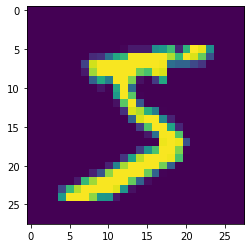

In [5]:
plt.imshow(image.squeeze()) #just visualizing

In [6]:
test_set

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
image, label = test_set[0]

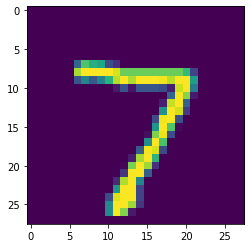

In [8]:
plt.imshow(image.squeeze())

In [9]:
train_labels = [train_set[i][1] for i in range(len(train_set))]
test_labels = [test_set[i][1] for i in range(len(test_set))]

train_dist = Counter(train_labels)
test_dist = Counter(test_labels)

print("Training set label distribution:", train_dist)
print("Test set label distribution:", test_dist)

Training set label distribution: Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})
Test set label distribution: Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


## Taking a sample

In [10]:
train_sample = torch.utils.data.DataLoader(dataset = train_set, batch_size = 50, shuffle = True)
test_sample = torch.utils.data.DataLoader(dataset = test_set, batch_size = 50, shuffle = False)

In [29]:
# for i in range(10):
#     plt.subplot(1,10,i+1)
#     image, label = train_set[i]
#     plt.imshow(image.reshape((28,28)), cmap = "gray")

## Defining a MLP

In [60]:
#output 10 cause 10 classes
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_size = 784, output_size = 10, layers = [120,84]):
        super().__init__()
        self.l1 = nn.Linear(input_size, layers[0]) #the first hidden layer takes 784 and gives out 120, we can use dropout after this line to drop some so we get a better ans
        self.l2 = nn.Linear(layers[0], layers[1]) #2nd hidden layer takes 120 gives out 84, we can use dropout after this line to drop some so we get a better ans
        self.l3 = nn.Linear(layers[1], output_size) #output layer takes 84 gives out 10
        
    def forward(self,X):
        X = F.relu(self.l1(X))
        X = F.relu(self.l2(X))
        X = self.l3(X)
        return F.log_softmax(X, dim = 1)
model1 = MultilayerPerceptron()

In [63]:
print(model1)

MultilayerPerceptron(
  (l1): Linear(in_features=784, out_features=120, bias=True)
  (l2): Linear(in_features=120, out_features=84, bias=True)
  (l3): Linear(in_features=84, out_features=10, bias=True)
)


In [64]:
criterion1 = nn.CrossEntropyLoss() #loss
optimizer1 = torch.optim.Adam(model1.parameters(), lr = 0.001)

## Training the model

In [33]:
for images, labels in train_sample:
    print("Inital sample shape", images.size())
    break
print("Batch size after reshaping", images.view(50,-1).size())

Inital sample shape torch.Size([50, 1, 28, 28])
Batch size after reshaping torch.Size([50, 784])


In [41]:
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b, (x_train,y_train) in enumerate(train_sample):
        b += 1
        
        y_pred = model1(x_train.view(50, -1)) #we flatten it so the input is 784
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1] #takes the one with the highest prob
        batch_corr = (predicted == y_train).sum() 
        trn_corr += batch_corr
        
        optimizer.zero_grad() #reset the gradients after training
        loss.backward() #backprop
        optimizer.step() #updates the parameter
        
        if b%600 == 0:
            accuracy = (trn_corr.item() / ((b+1) * 50)) * 100
            print(f'epoch: {i:2} batch: {b:4} [{100*b:6}/60000] Train loss: {loss.item():10.8f} Train accuracy: {accuracy:.2f}%' )
    
    train_losses.append(loss)
    train_correct.append(trn_corr)

epoch:  0 batch:  600 [ 60000/60000] Train loss: 0.00333927 Train accuracy: 99.53%
epoch:  0 batch: 1200 [120000/60000] Train loss: 0.00015141 Train accuracy: 99.57%
epoch:  1 batch:  600 [ 60000/60000] Train loss: 0.00752747 Train accuracy: 99.51%
epoch:  1 batch: 1200 [120000/60000] Train loss: 0.01091244 Train accuracy: 99.56%
epoch:  2 batch:  600 [ 60000/60000] Train loss: 0.00012639 Train accuracy: 99.59%
epoch:  2 batch: 1200 [120000/60000] Train loss: 0.00541412 Train accuracy: 99.65%
epoch:  3 batch:  600 [ 60000/60000] Train loss: 0.03881312 Train accuracy: 99.60%
epoch:  3 batch: 1200 [120000/60000] Train loss: 0.00108259 Train accuracy: 99.57%
epoch:  4 batch:  600 [ 60000/60000] Train loss: 0.00028837 Train accuracy: 99.46%
epoch:  4 batch: 1200 [120000/60000] Train loss: 0.00272125 Train accuracy: 99.59%
epoch:  5 batch:  600 [ 60000/60000] Train loss: 0.00115897 Train accuracy: 99.72%
epoch:  5 batch: 1200 [120000/60000] Train loss: 0.00907595 Train accuracy: 99.72%
epoc

In [42]:
#testing how we do nograd so we dont calc gradients
with torch.no_grad():
        for b, (x_test,y_test) in enumerate(test_sample):
            y_val = model1(x_test.view(50,-1))

            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
loss = criterion(y_val,y_test)
test_losses.append(loss)
test_correct.append(tst_corr)    

In [43]:
print(f'test accuracy: {test_correct[-1].item()*100/10000:}%')

test accuracy: 97.9%


## MLP other method


In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.f1 = nn.Linear(28*28,50) #first layer output 50
        self.f2 = nn.Linear(50,50) #2nd layer output 50
        self.f3 = nn.Linear(50,10) #output layer
        
    def forward(self, X):
        X = X.view(-1, 28*28) #flattened it 
        X = F.relu(self.f1(X)) #using relu
        X = F.relu(self.f2(X))
        return F.log_softmax(self.f3(X), dim = 1)

modelz = Net()
optimizerr = torch.optim.Adam(modelz.parameters(), lr = 0.01)
criterionn = nn.CrossEntropyLoss()

print(modelz)

Net(
  (f1): Linear(in_features=784, out_features=50, bias=True)
  (f2): Linear(in_features=50, out_features=50, bias=True)
  (f3): Linear(in_features=50, out_features=10, bias=True)
)


In [30]:
def train(epoch, model, training_sample, optimizer, criterion, log_interval = 200):
    model.train()
    
    for batch_idx, (data,target) in enumerate(training_sample):
        optimizer.zero_grad() #reset the gradients every time
        
        output = model(data)
        
        loss = criterion(output,target) 
        
        loss.backward() #triggering backward
        
        optimizer.step() #updates the parameter
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(training_sample.dataset),
                100. * batch_idx / len(training_sample), loss.data.item()))

In [32]:
def validate(model, testing_sample, criterion, loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0,0
    
    with torch.no_grad():
        for data,target in testing_sample:
            output = model(data)
            val_loss += criterion(output, target).data.item()
            pred = output.data.max(1)[1]
            correct += pred.eq(target.data).sum().item()

    val_loss /= len(testing_sample)
    loss_vector.append(val_loss)
    accuracy = 100. *correct/ len(testing_sample.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(testing_sample.dataset), accuracy))

In [34]:
def looop(model, epochs, training_sample, testing_sample, optimizer, criterion,  lossv, accv):
    for epoch in range(1, epochs + 1):
        train(epoch, model, training_sample, optimizer, criterion)
        validate(model, testing_sample, criterion, lossv, accv)

In [35]:
epochss = 10
lossmv, accmv = [],[]
looop(model = modelz, epochs = epochss, training_sample = train_sample, testing_sample = test_sample,
      optimizer = optimizerr, criterion = criterionn, lossv = lossmv, accv = accmv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.080365
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.016592
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.019683
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.218085
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.097179
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.016176

Validation set: Average loss: 0.1923, Accuracy: 9595/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.017350
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.042540
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.094599
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.013284
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.178886
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.241559

Validation set: Average loss: 0.1721, Accuracy: 9596/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.006819
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.116139
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.060569
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.361430
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.092401
Train Epoch: 3 [50000/60000 (83

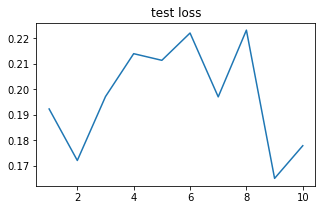

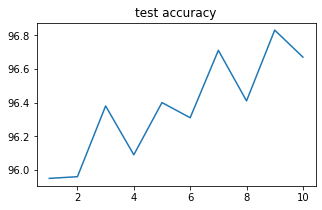

In [36]:
#visulaizing the loss and accuracy for each epoch
plt.figure(figsize = (5,3))
plt.plot(np.arange(1, epochss + 1), lossmv)
plt.title('test loss')

plt.figure(figsize = (5,3))
plt.plot(np.arange(1, epochss + 1), accmv)
plt.title('test accuracy');

## CNN


In [25]:
class Met(nn.Module):
    def __init__(self):
        super(Met, self).__init__()
        self.conv1 = nn.Conv2d(1,10, kernel_size = 5) #first hidden in 1(because grayscale) out 10
        self.conv2 = nn.Conv2d(10,20, kernel_size = 5)#2nd hidden in 10 out 20
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        #two convolution layers and 2 linear layrs
    def forward(self, X):
        X = F.relu(F.max_pool2d(self.conv1(X),2))
        X = F.relu(F.max_pool2d(self.conv2(X),2))
        X = X.view(-1, 320)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return F.log_softmax(X, dim = 1)  

In [26]:
network = Met()
optimizerc = torch.optim.Adam(network.parameters(), lr = 0.001)
criterionc = nn.CrossEntropyLoss()
print(network)

Met(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [27]:
epochss = 10
losscv, acccv = [],[]
looop(model = network, epochs = epochss, training_sample = train_sample, testing_sample = test_sample,
      optimizer = optimizerc, criterion = criterionc, lossv = losscv, accv = acccv)

Train Epoch: 10 [0/60000 (0%)]	Loss: 2.296530
Train Epoch: 10 [10000/60000 (17%)]	Loss: 0.220446
Train Epoch: 10 [20000/60000 (33%)]	Loss: 0.111042
Train Epoch: 10 [30000/60000 (50%)]	Loss: 0.045579
Train Epoch: 10 [40000/60000 (67%)]	Loss: 0.217397
Train Epoch: 10 [50000/60000 (83%)]	Loss: 0.029151

Validation set: Average loss: 0.0755, Accuracy: 9746/10000 (97%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.064168
Train Epoch: 10 [10000/60000 (17%)]	Loss: 0.043567
Train Epoch: 10 [20000/60000 (33%)]	Loss: 0.066392
Train Epoch: 10 [30000/60000 (50%)]	Loss: 0.058482
Train Epoch: 10 [40000/60000 (67%)]	Loss: 0.170119
Train Epoch: 10 [50000/60000 (83%)]	Loss: 0.151623

Validation set: Average loss: 0.0533, Accuracy: 9835/10000 (98%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.049813
Train Epoch: 10 [10000/60000 (17%)]	Loss: 0.014604
Train Epoch: 10 [20000/60000 (33%)]	Loss: 0.078536
Train Epoch: 10 [30000/60000 (50%)]	Loss: 0.002273
Train Epoch: 10 [40000/60000 (67%)]	Loss: 0.190528
Train Epoch: 1

Text(0.5, 1.0, 'test accuracy')

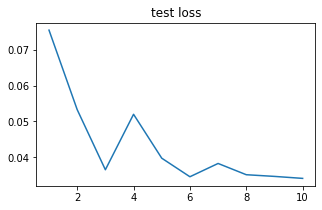

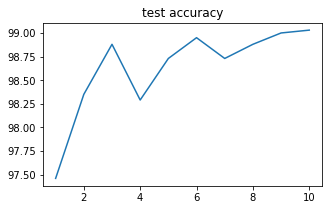

In [29]:
plt.figure(figsize = (5,3))
plt.plot(np.arange(1, epochss + 1), losscv)
plt.title('test loss')

plt.figure(figsize = (5,3))
plt.plot(np.arange(1, epochss + 1), acccv)
plt.title('test accuracy')